<a href="https://colab.research.google.com/github/ychervonyi/reinforcement-learning-learning/blob/main/racetrack_monte_carlo_chapter5_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
from collections import Counter
from matplotlib import pyplot
from tqdm import tqdm

np.random.seed(1231231)


class Point:
    def __init__(self, rr, cc):
        self.y = rr
        self.x = cc


def collinear(p1, p2, p3):
    """
    Return true iff p1, p2, and p3 all lie on the same line.
    """
    return (p2.x - p1.x) * (p3.y - p1.y) == (p3.x - p1.x) * (p2.y - p1.y)


def within(a, b, c):
    """
    Return true iff b is between a and c (inclusive).
    """
    return a <= b <= c or c <= b <= a


class Segment:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.A = p2.y - p1.y
        self.B = p1.x - p2.x
        self.C = self.A * p1.x + self.B * p1.y

    def print(self):
        print(f"x1: {self.p1.x}, y1: {self.p1.y}")
        print(f"x2: {self.p2.x}, y2: {self.p2.y}")

    def p_is_on(self, p):
        return (collinear(self.p1, self.p2, p)
                and (within(self.p1.x, p.x, self.p2.x) if self.p1.x != self.p2.x else
                     within(self.p1.y, p.y, self.p2.y)))


def segments_intersect(s1, s2):
    """
    Check if two segments intersect.
    """
    A1, B1, C1 = s1.A, s1.B, s1.C
    A2, B2, C2 = s2.A, s2.B, s2.C
    det = A1 * B2 - A2 * B1
    if det == 0:
        return False
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det

    for s in (s1, s2):
        x1, x2 = s.p1.x, s.p2.x
        y1, y2 = s.p1.y, s.p2.y
        if not (min(x1, x2) <= x <= max(x1, x2) and min(y1, y2) <= y <= max(y1, y2)):
            return False
    return True


def compare_points(p1, p2):
    """
    Check if two points are the same.
    """
    return p1.x == p2.x and p1.y == p2.y


def compare_segments(s1, s2):
    """
    Check if two segments are the same.
    """
    return compare_points(s1.p1, s2.p1) and compare_points(s1.p2, s2.p2)


class Environment:
    def __init__(self):
        self.build()

    def build(self):
        """
        Build an environment.
        """
        print("Building an environment...")
        # NOTE: this is an ugly way to define the track geometry
        # Here we define the track as a polygon
        rows = 30
        cols = 15

        self.max_v, self.min_v = 5, 0
        self.rows, self.cols = rows, cols
        self.state_tuple = (rows, cols, self.max_v, self.max_v)

        self.start_segment = Segment(Point(0, 0), Point(0, 10))
        print("Start line:")
        self.start_segment.print()
        self.finish_segment = Segment(Point(10, 15), Point(30, 15))
        print("Finish line:")
        self.finish_segment.print()

        # Define start points
        self.start_points = []
        r = 0
        for c in range(1, 10):
            self.start_points.append((r, c))

        # Boundaries
        points = [
            Point(0, 0),
            Point(0, 10),
            Point(10, 10),
            Point(10, 15),
            Point(30, 15),
            Point(30, 0)
        ]

        # Bounds should not have start and finish lines
        self.bounds = []
        for i in range(1, len(points)):
            s = Segment(points[i - 1], points[i])
            if compare_segments(s, self.finish_segment) or compare_segments(s, self.start_segment):
                continue
            print(f"Adding boundary...")
            s.print()
            self.bounds.append(s)

        self.bounds.append(Segment(points[-1], points[0]))
        print(f"Adding boundary...")
        self.bounds[-1].print()

        self.build_all_actions()

    def build_all_actions(self):
        """
        Build all actions.
        """
        dv = [-1, 0, 1]
        n_dv = len(dv)
        self.all_actions_map = {}
        self.all_actions = []
        for i, d_vr in enumerate(dv):
            for j, d_vc in enumerate(dv):
                self.all_actions.append((d_vr, d_vc))
                self.all_actions_map[f"{d_vr}_{d_vc}"] = i * n_dv + j
        self.n_actions = len(self.all_actions)

    def is_good_velocity(self, vr_, vc_):
        """
        Check if velocity is allowed.
        """
        if (vr_, vc_) == (
        self.min_v, self.min_v) or vr_ < self.min_v or vr_ >= self.max_v or vc_ < self.min_v or vc_ >= self.max_v:
            return False
        return True

    def get_possible_action_indices(self, vr_, vc_):
        """
        Get possible actions for current velocity `vr_, vc_`.
        """
        # 9 actions for each state - increase, decrease or
        # don't change velocity components

        possible_actions_indicies = []
        for d_vr, d_vc in self.all_actions:
            if self.is_good_velocity(vr_ + d_vr, vc_ + d_vc):
                possible_actions_indicies.append(self.all_actions_map[f"{d_vr}_{d_vc}"])
        return possible_actions_indicies

    def get_episode(self, policy_fn):
        """
        Generate an episode.
        """
        hits = 0
        reward = -1
        vr = vc = 0
        r, c = self.start_points[np.random.randint(0, len(self.start_points))]
        finish = False
        history = []
        while not finish:
            d_vr, d_vc, prob = policy_fn(r, c, vr, vc)
            new_vr, new_vc = vr + d_vr, vc + d_vc

            assert not (new_vr == 0 and new_vc == 0 and (r, c) in self.start_points), f"{new_vr} {new_vc} {r} {c}"

            # Check if the new path intersects finish line
            # If yes we are done with this episode
            new_path = Segment(Point(r, c), Point(r + new_vr, c + new_vc))
            if segments_intersect(self.finish_segment, new_path):
                history.append((r, c, vr, vc, d_vr, d_vc, 0, prob))
                break

            # Check if the path intersects boundaries
            # If yes we move the car to the start line
            hit = False
            for bound in self.bounds:
                if segments_intersect(bound, new_path):
                    hit = True
                    # TODO: Worse reward for hitting a boundary?
                    history.append((r, c, vr, vc, d_vr, d_vc, -5, prob))
                    hits += 1
                    r, c = self.start_points[np.random.randint(0, len(self.start_points))]
                    vr = vc = 0

            # Update velocity and position if didn't hit a bound
            if not hit:
                history.append((r, c, vr, vc, d_vr, d_vc, -1, prob))
                vr, vc = new_vr, new_vc
                r += vr
                c += vc
        return history, hits

    def plot_episode(self, history):
        track = np.zeros((self.rows, self.cols))
        pyplot.imshow(track)
        for item in history:
            # r, c, vr, vc, d_vr, d_vc, reward, p = item
            pyplot.plot(item[1], item[0], '.r')
        pyplot.show()

    def print_episode(self, history):
        """
        Follow `history` and print how many times
        each cell was visited.
        """
        track = np.zeros((self.rows, self.cols))
        for item in history:
            # r, c, vr, vc, d_vr, d_vc, reward, p = item
            track[item[0], item[1]] += 1
        return track.astype("int")

In [8]:
class Agent:
    """
    Agent contains Q function, policy and C. Policy is determined 
    from Q function.
    Agent also contains policies.
    """
    def __init__(self, env, epsilon=0.1):
        self.env = env
        # Value function
        self.Q = np.random.uniform(
            low=0,
            high=self.env.n_actions,
            size=self.env.state_tuple + (self.env.n_actions,)
        )
        # self.Q = np.zeros(self.env.state_tuple + (self.env.n_actions,))

        # Cumulative sum of weights
        self.C = np.zeros(self.env.state_tuple + (self.env.n_actions,))
        # Policy
        # self.policy = np.argmax(Q, axis=4)
        # self.policy = np.zeros((rows, cols))
        self.policy_init_value = -1
        self.policy = np.full(self.env.state_tuple, self.policy_init_value)

        self.epsilon = epsilon

    def random_policy(self, r, c, vr, vc):
        """
        Get possible actions from the environment and 
        choose one random action out of the possible actions.

        Returns a tuple `(dvr, dvc, action probability)`.
        """
        possible_action_indices = self.env.get_possible_action_indices(vr, vc)
        assert not len(possible_action_indices) == 0, f"No possible actions for {r, c, vr, vc}"
        prob = 1 / len(possible_action_indices)
        a_index = np.random.choice(possible_action_indices)
        return self.env.all_actions[a_index] + (prob, )

    def soft_greedy_policy(self, r, c, vr, vc):
        """
        Get possible actions from the environment, 
        choose one random action out of the possible actions with 
        probability `epsilon` or return learned action if it is allowed.

        Returns a tuple `(dvr, dvc, action probability)`.
        """
        possible_action_indices = self.env.get_possible_action_indices(vr, vc)
        assert not len(possible_action_indices) == 0, f"No possible actions for {r, c, vr, vc}"
        prob = 1 / len(possible_action_indices)

        if np.random.rand() > self.epsilon and self.policy[r, c, vr, vc] in possible_action_indices:
            a_index = self.policy[r, c, vr, vc]
        else:
            a_index = np.random.choice(possible_action_indices)
        return self.env.all_actions[a_index] + (prob, )

    def greedy_policy(self, r, c, vr, vc):
        """
        Get possible actions from the environment, 
        choose one random action out of the possible actions
         or return learned action if it is allowed.

        Returns a tuple `(dvr, dvc, action probability)`.
        """
        possible_action_indices = self.env.get_possible_action_indices(vr, vc)
        assert not len(possible_action_indices) == 0, f"No possible actions for {r, c, vr, vc}"
        prob = 1 / len(possible_action_indices)

        if self.policy[r, c, vr, vc] in possible_action_indices:
            a_index = self.policy[r, c, vr, vc]
        else:
            a_index = np.random.choice(possible_action_indices)
        return self.env.all_actions[a_index]+ (prob, )

In [22]:
class MonteCarlo:
    def __init__(self, agent, env):
        self.gamma = 1
        self.agent = agent
        self.env = env
        self.n_elements = self.agent.policy.size

    def learn_episode(self, history):
        """
        Off policy Monte-Carlo control algorithm (p. 111 in Sutton&Barto)
        Learn from an episode encoded in `history`.
        """
        G = 0
        W = 1
        steps_followed_back = 0
        for i in range(len(history) - 1, -1, -1):
            r, c, vr, vc, d_vr, d_vc, reward, prob = history[i]
            a_index = self.env.all_actions_map[f"{d_vr}_{d_vc}"]
            G = self.gamma * G + reward
            self.agent.C[r, c, vr, vc, a_index] += W
            self.agent.Q[r, c, vr, vc, a_index] += W / self.agent.C[r, c, vr, vc, a_index] * (
                        G - self.agent.Q[r, c, vr, vc, a_index])
            self.agent.policy[r, c, vr, vc] = np.argmax(self.agent.Q[r, c, vr, vc])

            # NOTE: Learns very slow if next lines are uncommented
            # This is a known problem (see Sutton&Barto p. 111 first paragraph)
            # if self.agent.policy[r, c, vr, vc] != a_index:
            #     break
            # W /= prob

            steps_followed_back += 1
        return steps_followed_back

    def optimize(self, train_episodes, eval_episodes):
        """
        Apply Monte-Carlo algorith - generate an episode and learn 
        from it. Every 1000 episodes evaluate the greedy policy.
        """
        steps_cnt = []
        steps_followed_by_algorithm = 0
        total_steps = 0

        # for ep in tqdm(range(train_episodes)):
        for ep in range(train_episodes):
            if ep % 1000 == 0:
                # Fraction of learned parameters in policy
                frac_params = np.count_nonzero(self.agent.policy != self.agent.policy_init_value) / self.n_elements
                print(f"Episodes: {ep}/{train_episodes},  policy: {round(frac_params * 100, 2)}%")
                evaluate_greedy_policy(eval_episodes, self.agent, self.env)
                if ep != 0:
                    print(f"Fraction of trajectory steps followed by algorithm: {round(steps_followed_by_algorithm / total_steps * 100, 2)}%")
                    total_steps = 0
                    steps_followed_by_algorithm = 0
            hist, hits = self.env.get_episode(self.agent.random_policy)
            total_steps += len(hist)
            steps_cnt.append(len(hist))
            steps_followed_by_algorithm += self.learn_episode(hist)


def evaluate_greedy_policy(n_episodes, agent, env):
    """
    Generate episodes using greedy policy and compute average number 
    of times the car hits the boundaries.
    """
    total_hits = 0
    for _ in range(n_episodes):
        hist, n_hits = env.get_episode(agent.greedy_policy)
        total_hits += n_hits
    hits_per_episode = total_hits / n_episodes
    print(f"Average number of hits per episode: {round(hits_per_episode, 2)}")

In [23]:
track_env = Environment()
car_agent = Agent(track_env)
mc = MonteCarlo(car_agent, track_env)

Building an environment...
Start line:
x1: 0, y1: 0
x2: 10, y2: 0
Finish line:
x1: 15, y1: 10
x2: 15, y2: 30
Adding boundary...
x1: 10, y1: 0
x2: 10, y2: 10
Adding boundary...
x1: 10, y1: 10
x2: 15, y2: 10
Adding boundary...
x1: 15, y1: 30
x2: 0, y2: 30
Adding boundary...
x1: 0, y1: 30
x2: 0, y2: 0


In [26]:
mc.optimize(20000, 1000)

Episodes: 0/20000,  policy: 10.59%
Average number of hits per episode: 9.73
Episodes: 1000/20000,  policy: 10.62%
Average number of hits per episode: 9.43
Fraction of trajectory steps followed by algorithm: 0.07%
Episodes: 2000/20000,  policy: 10.66%
Average number of hits per episode: 9.72
Fraction of trajectory steps followed by algorithm: 0.07%
Episodes: 3000/20000,  policy: 10.69%
Average number of hits per episode: 9.33
Fraction of trajectory steps followed by algorithm: 0.09%
Episodes: 4000/20000,  policy: 10.72%
Average number of hits per episode: 10.02
Fraction of trajectory steps followed by algorithm: 0.06%
Episodes: 5000/20000,  policy: 10.77%
Average number of hits per episode: 9.84
Fraction of trajectory steps followed by algorithm: 0.08%
Episodes: 6000/20000,  policy: 10.82%
Average number of hits per episode: 9.74
Fraction of trajectory steps followed by algorithm: 0.06%
Episodes: 7000/20000,  policy: 10.84%
Average number of hits per episode: 9.76
Fraction of trajectory

Number of steps: 11, number of hits: 0


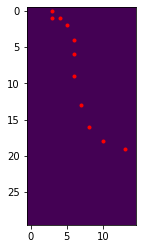

In [6]:
history, hits = track_env.get_episode(car_agent.greedy_policy)
print(f"Number of steps: {len(history)}, number of hits: {hits}")
track_env.plot_episode(history)